In [ ]:
# !pip install keras
# !pip install tensorflow==2.3.0

In [ ]:
#  !pip install --upgrade tensorflow_hub

Requirement already up-to-date: tensorflow_hub in /usr/local/lib/python3.6/dist-packages (0.9.0)


In [1]:
##코랩실행시 google driver mount 하기

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from google.colab import drive
drive.mount('/content/drive')
% cd /content/drive/My Drive/Diagnosis_Gallbladder_Cancer


# ## local에서 실행할 때 
# # get current path
# print("current file path: ",os.getcwd())

# #change Path
# new_path=os.chdir('../')
# print("new path:",new_path)

Mounted at /content/drive
/content/drive/My Drive/Diagnosis_Gallbladder_Cancer


In [2]:
! pip install pydicom

     |████████████████████████████████| 1.9MB 5.9MB/s 


In [ ]:
import pydicom as pdc
import matplotlib.pyplot as plt
from IPython.display import display, Image
import numpy as np
import cv2
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout
# import tensorflow_hub as hub
%pylab inline
import glob
from PIL import Image

Populating the interactive namespace from numpy and matplotlib


In [ ]:
path = 'metadata/'
# Load Meta-data and preprocessing
patient_meta = pd.read_csv(path + 'patient_meta.csv')
patient_meta = patient_meta[['RANDOM_PT_NO','SEX','AGE',"DX"]]
#patient_meta.head()

#NET, Lymphoma : Dropped (3 cases)
print("Drop:", patient_meta[(patient_meta['DX']=='lymphoma') | (patient_meta['DX']=='NET')].index)
patient_meta = patient_meta.drop(patient_meta[(patient_meta['DX']=='lymphoma') | (patient_meta['DX']=='NET')].index, axis=0)
patient_meta.reset_index(drop=True, inplace=True)

# categorical Variables(Sex, Phase)
# pd.get_dummies() 가변수 만들기
patient_meta = pd.concat([patient_meta, pd.get_dummies(patient_meta[['SEX']])], axis=1)
patient_meta = patient_meta.drop(['SEX'], axis=1)

# Continuous Variables(Age)
age = patient_meta['AGE'].values
age_scaled = preprocessing.scale(age)
 
patient_meta['AGE_NORM'] = age_scaled
patient_meta = patient_meta.drop(['AGE'], axis = 1)

#Label Setting
# 0 : Metastasis, 56
# 1 : Hepatocelluar Carcinoma, 30
# 2 : cholangiocarcinoma, 14 --> ????    # 숫자가 의미하는 것은??
for r in range(patient_meta.shape[0]):
    if('metastasis' in patient_meta.iloc[r, 1]):
        patient_meta.iloc[r, 1] = 0
    elif('HCC' == patient_meta.iloc[r, 1]):
        patient_meta.iloc[r, 1] = 1
    elif('cholangiocarcinoma' == patient_meta.iloc[r, 1]):
        patient_meta.iloc[r, 1] = 2
    else:
        patient_meta.iloc[r, 1] = -1

print(patient_meta.head())
patient_meta = np.array(patient_meta)   #넘파이 배열로 변환
# patient_meta.shape

Drop: Int64Index([42, 66, 69], dtype='int64')
  RANDOM_PT_NO DX  SEX_f  SEX_m  AGE_NORM
0   SN00180816  1      0      1 -0.971709
1   SN00361989  1      1      0 -1.065503
2   SN00481545  2      1      0  0.904177
3   SN00493709  2      0      1  0.435205
4   SN00181638  0      0      1 -0.315149


In [ ]:
label_df = pd.read_csv('metadata/label_df.csv')
label_df.head()

,patient_no,img_idx,mean_annotation,DX
0,SN00017916,1,0.0,0
1,SN00017916,2,0.0,0
2,SN00017916,3,0.0,0
3,SN00017916,4,0.0,0
4,SN00017916,5,0.0,0


In [ ]:
# 1 patient 당 DX list 가져오기
grouped_df=label_df.groupby('patient_no').agg(list)
temp_list=grouped_df.loc['SN00017916','DX']

In [ ]:
#  sorted(glob.glob('./benchmark_liver_tumor/raw/'+'SN00017916'+'/*.dcm'))
pdc.dcmread('./benchmark_liver_tumor/raw/SN00017916/SN00017916_0020.dcm').pixel_array.shape

(512, 512)

In [ ]:
print(f"한개의 dcm 이미지가 세로, 가로 각각 {512/32}개로 나뉘어져 총 {(512/32)**2}개의 pixel로 나눠져야함" )

한개의 dcm 이미지가 세로, 가로 각각 16.0개로 나뉘어져 총 256.0개의 pixel로 나눠져야함


In [ ]:
# Save Dataset
save_path = 'models/original_size_np/'

In [ ]:
path = 'metadata/'
# Load Meta-data and preprocessing
patient_dx = pd.read_csv(path + 'patient_meta.csv')
patient_dx = patient_dx[['RANDOM_PT_NO',"DX"]]
#patient_meta.head()

#NET, Lymphoma : Dropped (3 cases)
print("Drop:", patient_dx[(patient_dx['DX']=='lymphoma') | (patient_dx['DX']=='NET')].index)
patient_dx = patient_dx.drop(patient_dx[(patient_dx['DX']=='lymphoma') | (patient_dx['DX']=='NET')].index, axis=0)
patient_dx.reset_index(drop=True, inplace=True)

def find_disease(patient_no):
    dx=np.array(patient_dx[patient_dx['RANDOM_PT_NO'] == patient_no]['DX'])[0]
    if 'metastasis'in dx:
        return 1
    elif dx == 'HCC':
        return 2
    elif dx == 'cholangiocarcinoma':
        return 3
    else:
        return 0

Drop: Int64Index([42, 66, 69], dtype='int64')


## Make Dataset(npy files)

In [ ]:
# 1 patient 당 DX list 가져오기
# sliding-window Proprocessing (길이가 다른 z 축데이터를 동일하게 만들어준다.)
window_size = 5
size = (64,64) #resize 임시로 함(서버 사용 불가능할 때)
n_ct_statistics=[]
# 10-cv Settings
kf = KFold(n_splits=5, random_state=None, shuffle=True)
for tr_list, te_list in kf.split(patient_meta):
    # Save Dataset
    path = 'models/original_size_np/'
    # Train Dataset
    X_p_tr, X_m_tr, X_i_tr, Y_tr = [], [], [], []

    ####### X train
    for tr_idx in tr_list:
        patient_no = patient_meta[tr_idx, 0]
        X_i_tr_ct_list =  sorted(glob.glob('./benchmark_liver_tumor/raw/'+patient_no+'/*.dcm'))
        n_ct = len(X_i_tr_ct_list)
        # Load 3D CT Data per Patient
        ct_block = [] #사진
        label_block = [] # annotation label
        for z in range(n_ct):
#             ct_block.append(cv2.resize(cv2.normalize(pdc.dcmread(X_i_tr_ct_list[z]).pixel_array, dst=None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F), dsize=size))
            ct_block.append(cv2.normalize(cv2.resize(pdc.dcmread(X_i_tr_ct_list[z]).pixel_array,dsize=size), dst=None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F))
        ct_block = np.array(ct_block)
        # Sliding-window Preprocess
        n_window = n_ct-window_size+1
        X_i_tr_buffer = [] # window size 만큼 겹쳐서 잘라진 3d 이미지
#         DX_list=grouped_df.loc[patient_no,'DX']# 1 patient 당 DX list 가져오기
        for z in range(n_window):
            X_i_tr_buffer.append(ct_block[z:z+window_size]) # buffer에 겹쳐서 들어감
            # dx = find_disease(patient_no) if np.mean([label.mean() for label in label_block[z:z+window_size]]) >0.0 else 0
            X_p_tr.append(patient_no)# patient number
            X_m_tr.append(patient_meta[tr_idx, 2:])#meta 정보 전체 

        X_i_tr_buffer = np.array(X_i_tr_buffer)
        X_i_tr.extend(X_i_tr_buffer)
        print(f"{patient_no} X train done!")

    X_p_tr, X_m_tr, X_i_tr= np.array(X_p_tr), np.array(X_m_tr), np.array(X_i_tr)
    print(X_p_tr.shape, X_m_tr.shape, X_i_tr.shape)
    np.save(save_path+'np/X_p_tr', X_p_tr), np.save(save_path+'np/X_m_tr', X_m_tr), np.save(save_path+'np/X_i_tr', X_i_tr)
    del(X_p_tr)
    del(X_m_tr)
    del(X_i_tr)
    del(X_i_tr_buffer)

    print("train X done!")
    print("="*20)
    for tr_idx in tr_list:
        patient_no = patient_meta[tr_idx, 0]
        Y_i_tr_label_list =  sorted(glob.glob('./benchmark_liver_tumor/raw/'+patient_no+'/label/*.png'))
        n_ct = len(Y_i_tr_label_list)
        # Load 3D CT Data per Patient
        label_block = [] # annotation label
        for z in range(n_ct):
            im = Image.open(Y_i_tr_label_list[z])
            im = np.array(im.resize(size))
            label_block.append(im)
        ct_block = np.array(ct_block)
        label_block = np.array(label_block)
        # Sliding-window Preprocess
        n_window = n_ct-window_size+1
#         DX_list=grouped_df.loc[patient_no,'DX']# 1 patient 당 DX list 가져오기
        Y_i_tr_buffer = []
        for z in range(n_window):
            # dx = find_disease(patient_no) if np.mean([label.mean() for label in label_block[z:z+window_size]]) >0.0 else 0
            Y_i_tr_buffer.append(label_block[z:z+window_size]) #buffer에 annotation 겹쳐서 들어감
#             Y_tr.append(patient_meta[tr_idx, 1]) 
            # Y_tr.append(max(DX_list[z:z+window_size])) # label df에서 환자정보, 몇번째 사진인지  input을 넣어주면 dx중에서 max를 가져옴
        Y_i_tr_buffer = np.array(Y_i_tr_buffer)
        Y_tr.extend(Y_i_tr_buffer)
        print(f"{patient_no} Y train done!")
    Y_tr =  np.array(Y_tr)
    print( Y_tr.shape)
    assert (Y_tr.shape[2],Y_tr.shape[3]) == size, "y값 shape이 안맞습니다!"
    np.save(save_path+'np/Y_tr', Y_tr)
    del(Y_tr)
    del(Y_i_tr_buffer)
    print("Y train done!")
    print("="*20)


#---------------------------------------------------------------------------------------------------------------------

    # patient number, meta정보, window size 갯수만큼 겹쳐진 CT 사진, window 마다 y값(max함)
    # Test Dataset
    X_p_te, X_m_te, X_i_te, Y_te = [], [], [], []

    # X Test 
    for te_idx in te_list:
        patient_no = patient_meta[te_idx, 0]
        X_i_te_ct_list =  sorted(glob.glob('./benchmark_liver_tumor/raw/'+patient_no+'/*.dcm'))
        n_ct = len(X_i_te_ct_list)
        # Load 3D CT Data per Patient
        ct_block = [] #사진
        for z in range(n_ct):
            ct_block.append(cv2.normalize(cv2.resize(pdc.dcmread(X_i_te_ct_list[z]).pixel_array,dsize=size), dst=None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F))
        ct_block = np.array(ct_block)
        # Sliding-window Preprocess
        n_window = n_ct-window_size+1
        X_i_te_buffer = []
        DX_list=grouped_df.loc[patient_no,'DX']# 1 patient 당 DX list 가져오기
        for z in range(n_window):
            X_i_te_buffer.append(ct_block[z:z+window_size]) # buffer에 겹쳐서 들어감
            X_p_te.append(patient_no)# patient number
            X_m_te.append(patient_meta[tr_idx, 2:])#meta 정보 전체 
#             Y_tr.append(patient_meta[tr_idx, 1]) 
            # Y_tr.append(max(DX_list[z:z+window_size])) # label df에서 환자정보, 몇번째 사진인지  input을 넣어주면 dx중에서 max를 가져옴
        X_i_te_buffer = np.array(X_i_te_buffer)
        X_i_te.extend(X_i_te_buffer)
        print(f"{patient_no} X test done!")
    X_p_te, X_m_te, X_i_te= np.array(X_p_te), np.array(X_m_te), np.array(X_i_te)
    print(X_p_te.shape, X_m_te.shape, X_i_te.shape)
    np.save(save_path+'np/X_p_te', X_p_te), np.save(save_path+'np/X_m_te', X_m_te), np.save(save_path+'np/X_i_te', X_i_te)
    del(X_p_te)
    del(X_m_te)
    del(X_i_te)
    del(X_i_te_buffer)
    print("X test done!")
    print("="*20)

    #Y Test
    for te_idx in te_list:
        patient_no = patient_meta[te_idx, 0]
        Y_i_te_label_list =  sorted(glob.glob('./benchmark_liver_tumor/raw/'+patient_no+'/label/*.png'))
        n_ct = len(Y_i_te_label_list)
        # Load 3D CT Data per Patient
        label_block = [] # annotation label
        for z in range(n_ct):
            im = Image.open(Y_i_te_label_list[z])
            im = np.array(im.resize(size))
            label_block.append(im)
        label_block = np.array(label_block)
        # Sliding-window Preprocess
        n_window = n_ct-window_size+1
        Y_i_te_buffer = []
        DX_list=grouped_df.loc[patient_no,'DX']# 1 patient 당 DX list 가져오기
        for z in range(n_window):
            #dx = find_disease(patient_no) if np.mean([label.mean() for label in label_block[z:z+window_size]]) >0.0 else 0
            Y_i_te_buffer.append(label_block[z:z+window_size]) #buffer에 annotation 겹쳐서 들어감
#             Y_tr.append(patient_meta[tr_idx, 1]) 
            # Y_tr.append(max(DX_list[z:z+window_size])) # label df에서 환자정보, 몇번째 사진인지  input을 넣어주면 dx중에서 max를 가져옴
        Y_i_te_buffer = np.array(Y_i_te_buffer)
        Y_te.extend(Y_i_te_buffer)
        print(f"{patient_no} Y test done!")
    Y_te = np.array(Y_te)
    print(Y_te.shape)
    np.save(save_path+'np/Y_te', Y_te)
    del(Y_te)
    print("Y test done!")
    print("="*20)
    break

SN00180816 X train done!
SN00481545 X train done!
SN00493709 X train done!
SN00181638 X train done!
SN00222863 X train done!
SN00283964 X train done!
SN00304545 X train done!
SN00450700 X train done!
SN00090078 X train done!
SN00369027 X train done!
SN00474278 X train done!
SN00305004 X train done!
SN00508618 X train done!
SN00067936 X train done!
SN00407113 X train done!
SN00097002 X train done!
SN00133173 X train done!
SN00116934 X train done!
SN00141501 X train done!
SN00179194 X train done!
SN00289590 X train done!
SN00361258 X train done!
SN00305492 X train done!
SN00183359 X train done!
SN00397757 X train done!
SN00527433 X train done!
SN00062921 X train done!
SN00203040 X train done!
SN00266417 X train done!
SN00454145 X train done!
SN00274538 X train done!
SN00531159 X train done!
SN00553244 X train done!
SN00257665 X train done!
SN00108649 X train done!
SN00177221 X train done!
SN00431554 X train done!
SN00435072 X train done!
SN00459113 X train done!
SN00532977 X train done!


## Load Dataset(npy files)

In [ ]:
# Load Dataset
path = 'models/original_size_np/np/'
X_p_tr, X_m_tr, X_i_tr, Y_tr = np.load(path+'X_p_tr.npy'), np.load(path+'X_m_tr.npy', allow_pickle=True), np.load(path+'X_i_tr.npy'), np.load(path+'Y_tr.npy', allow_pickle=True)
X_p_te, X_m_te, X_i_te, Y_te = np.load(path+'X_p_te.npy'), np.load(path+'X_m_te.npy', allow_pickle=True), np.load(path+'X_i_te.npy'), np.load(path+'Y_te.npy', allow_pickle=True)
X_m_tr, X_m_te = X_m_tr.astype('float32'), X_m_te.astype('float32')
# Y_tr_cat, Y_te_cat = to_categorical(Y_tr), to_categorical(Y_te) # one-hot-encode
print(X_p_tr.shape, X_m_tr.shape, X_i_tr.shape, Y_tr.shape)
print(X_p_te.shape, X_m_te.shape, X_i_te.shape, Y_te.shape)

(10817,) (10817, 3) (10817, 5, 64, 64) (10817, 5, 64, 64)
(2590,) (2590, 3) (2590, 5, 64, 64) (2590, 5, 64, 64)


In [ ]:
X_i=np.concatenate((X_i_tr,X_i_te),axis=0)
Y = np.concatenate((Y_tr,Y_te),axis=0)
from sklearn.model_selection import train_test_split
X_i_tr, X_i_te, Y_tr, Y_te = train_test_split(X_i, Y, test_size=0.3, random_state=42)

In [ ]:
# Permute Channels
X_i_tr = np.rollaxis(X_i_tr, 1, 4)
X_i_te = np.rollaxis(X_i_te, 1, 4)
Y_tr = np.rollaxis(Y_tr, 1, 4)
Y_te = np.rollaxis(Y_te, 1, 4)
print(X_i_tr.shape)
print(X_i_te.shape)
print(Y_tr.shape)
print(Y_te.shape)

(8982, 64, 64, 5)
(4425, 64, 64, 5)
(8982, 64, 64, 5)
(4425, 64, 64, 5)


In [ ]:
# patient, Y(annotation img)
for p,y in zip(X_p_tr,Y_tr):
    print(p,y.shape)
    break
find_disease(p)

SN00180816 (64, 64, 5)


2

In [ ]:
# window size의 이미지 뭉치를 넣으면  patch 로 나누어주는 함수
def one_window2patches(one_window_ct, pixel_size=(32,32),islabel=False,patient_no=None):
    patch_ct_list = []
    ct_width, ct_height = one_window_ct.shape[0], one_window_ct.shape[1]
    for i in range(ct_width//pixel_size[0]):
        for j in range(ct_height//pixel_size[1]):
            patch_ct=one_window_ct[i*pixel_size[0]:(i+1)*pixel_size[0], j*pixel_size[1]:(j+1)*pixel_size[1]]
            if islabel:
                patch_ct=find_disease(patient_no) if np.mean([one_annotation.mean() for one_annotation in patch_ct]) > 0.0 else 0
            patch_ct_list.append(patch_ct)
    return np.array(patch_ct_list)

patch_list_ct = []
patch_list_label = []

## train image
for one_window_ct in X_i_tr:
    patch_list_ct.extend(one_window2patches(one_window_ct))
X_i_tr = np.array(patch_list_ct)

## train label
for patient_no,one_window_lable in zip(X_p_tr,Y_tr):
    result= one_window2patches(one_window_lable,islabel=True,patient_no=patient_no)
    patch_list_label.extend(result)
Y_tr = np.array(patch_list_label)

## initialize
patch_list_ct = []
patch_list_label = []

## train image
for one_window_ct in X_i_te:
    patch_list_ct.extend(one_window2patches(one_window_ct))
X_i_te = np.array(patch_list_ct)

## train label
for patient_no,one_window_lable in zip(X_p_tr,Y_te):
    result= one_window2patches(one_window_lable,islabel=True,patient_no=patient_no)
    patch_list_label.extend(result)
Y_te = np.array(patch_list_label)

Y_tr_cat, Y_te_cat = to_categorical(Y_tr), to_categorical(Y_te) # one-hot-encode

print(X_i_tr.shape, Y_tr.shape, Y_tr_cat.shape)
print(X_i_te.shape, Y_te.shape, Y_tr_cat.shape)


(35928, 32, 32, 5) (35928,) (35928, 4)
(17700, 32, 32, 5) (17700,) (35928, 4)


## Model Train


In [ ]:
# Build Model (3D-CNN)
# trail 1
'''
cnn_input = tf.keras.Input((X_i_tr.shape[1], X_i_tr.shape[2], X_i_tr.shape[3]))
h = tf.keras.layers.Reshape((X_i_tr.shape[1], X_i_tr.shape[2], X_i_tr.shape[3], 1))(cnn_input)
h = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', activation='tanh')(h)
h = tf.keras.layers.MaxPool3D((2, 2, 1))(h)
h = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', activation='tanh')(h)
h = tf.keras.layers.MaxPool3D((2, 2, 1))(h)
h = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', activation='tanh')(h)
h = tf.keras.layers.MaxPool3D((3, 3, 1))(h)
h = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', activation='tanh')(h)
h = tf.keras.layers.MaxPool3D((2, 2, 1))(h)
h = tf.keras.layers.Dropout(0.5)(h)
h = tf.keras.layers.Flatten()(h)
h = tf.keras.layers.Dense(128, activation='tanh')(h)
h = tf.keras.layers.Dense(64, activation='tanh')(h)
cnn_output = tf.keras.layers.Dense(Y_tr_cat.shape[1], activation='softmax')(h)
cnn = tf.keras.Model(cnn_input, cnn_output)
cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn.summary()
'''

"\ncnn_input = tf.keras.Input((X_i_tr.shape[1], X_i_tr.shape[2], X_i_tr.shape[3]))\nh = tf.keras.layers.Reshape((X_i_tr.shape[1], X_i_tr.shape[2], X_i_tr.shape[3], 1))(cnn_input)\nh = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', activation='tanh')(h)\nh = tf.keras.layers.MaxPool3D((2, 2, 1))(h)\nh = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', activation='tanh')(h)\nh = tf.keras.layers.MaxPool3D((2, 2, 1))(h)\nh = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', activation='tanh')(h)\nh = tf.keras.layers.MaxPool3D((3, 3, 1))(h)\nh = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', activation='tanh')(h)\nh = tf.keras.layers.MaxPool3D((2, 2, 1))(h)\nh = tf.keras.layers.Dropout(0.5)(h)\nh = tf.keras.layers.Flatten()(h)\nh = tf.keras.layers.Dense(128, activation='tanh')(h)\nh = tf.keras.layers.Dense(64, activation='tanh')(h)\ncnn_output = tf.keras.layers.Dense(Y_tr_cat.shape[1], acti

In [ ]:
def custom_recall(input_class_idx):
    def recall(y_true, y_pred):
        class_id_true = K.argmax(y_true, axis=-1)
        class_id_pred = K.argmax(y_pred, axis=-1)
        recall_mask = K.cast(K.equal(class_id_true, input_class_idx), 'int32')
        class_recall_tensor = K.cast(K.equal(class_id_true, class_id_pred), 'int32') * recall_mask
        class_recall = K.cast(K.sum(class_recall_tensor), 'float32') / K.cast(K.maximum(K.sum(recall_mask), 1), 'float32')
        return class_recall
    return recall


cnn_input = tf.keras.Input((X_i_tr.shape[1], X_i_tr.shape[2], X_i_tr.shape[3]))
h = tf.keras.layers.Reshape((X_i_tr.shape[1], X_i_tr.shape[2], X_i_tr.shape[3], 1))(cnn_input)
h = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', activation='relu')(h)
h = tf.keras.layers.MaxPool3D((2, 2, 1))(h)
h = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', activation='relu')(h)
h = tf.keras.layers.MaxPool3D((2, 2, 1))(h)
h = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', activation='relu')(h)
h = tf.keras.layers.MaxPool3D((2, 2, 1))(h)
h = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', activation='relu')(h)
h = tf.keras.layers.MaxPool3D((2, 2, 1))(h)
h = tf.keras.layers.Flatten()(h)
h = tf.keras.layers.Dense(128, activation='relu')(h)
h = tf.keras.layers.Dense(64, activation='relu')(h)
cnn_output = tf.keras.layers.Dense(Y_tr_cat.shape[1], activation='softmax')(h)
cnn = tf.keras.Model(cnn_input, cnn_output)
cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy','Precision','Recall'])
#     cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy','Precision',custom_recall(0),custom_recall(1),custom_recall(2),custom_recall(3)])
cnn.summary()

# display(Image(filename="./model/cnn.png"))

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 5)]       0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 32, 32, 5, 1)      0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 32, 32, 5, 16)     144       
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 16, 16, 5, 16)     0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 16, 16, 5, 16)     2064      
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 8, 8, 5, 16)       0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 8, 8, 5, 16)      

In [ ]:
'''
from keras.models import Sequential
# Define the model
print(X_i_tr.shape[1], X_i_tr.shape[2], X_i_tr.shape[3])

model = tf.keras.models.Sequential([
    # 64 64 5
    tf.keras.layers.Conv3D(16, (2,2,2), activation='tanh', input_shape=(X_i_tr.shape[1], X_i_tr.shape[2], X_i_tr.shape[3],1)),
    tf.keras.layers.MaxPool3D((2, 2, 1)),

    tf.keras.layers.Conv3D(16, (2,2,2), activation='tanh'),
    tf.keras.layers.MaxPool3D((2, 2, 1)),

    tf.keras.layers.Conv3D(16, (2,2,2), activation='tanh'),
    tf.keras.layers.MaxPool3D((2, 2, 1)),

    tf.keras.layers.Conv3D(16, (2,2,2), activation='tanh'),
    tf.keras.layers.MaxPool3D((2, 2, 1)),

    # Dropout probability of 0.5. It means that 50% of the values comming into the Dropout layer will be set to zero
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='tanh'),
    tf.keras.layers.Dense(64, activation='tanh'),
    tf.keras.layers.Dense(2, activation='softmax')
])
'''


"\nfrom keras.models import Sequential\n# Define the model\nprint(X_i_tr.shape[1], X_i_tr.shape[2], X_i_tr.shape[3])\n\nmodel = tf.keras.models.Sequential([\n    # 64 64 5\n    tf.keras.layers.Conv3D(16, (2,2,2), activation='tanh', input_shape=(X_i_tr.shape[1], X_i_tr.shape[2], X_i_tr.shape[3],1)),\n    tf.keras.layers.MaxPool3D((2, 2, 1)),\n\n    tf.keras.layers.Conv3D(16, (2,2,2), activation='tanh'),\n    tf.keras.layers.MaxPool3D((2, 2, 1)),\n\n    tf.keras.layers.Conv3D(16, (2,2,2), activation='tanh'),\n    tf.keras.layers.MaxPool3D((2, 2, 1)),\n\n    tf.keras.layers.Conv3D(16, (2,2,2), activation='tanh'),\n    tf.keras.layers.MaxPool3D((2, 2, 1)),\n\n    # Dropout probability of 0.5. It means that 50% of the values comming into the Dropout layer will be set to zero\n    tf.keras.layers.Dropout(0.5),\n    tf.keras.layers.Flatten(),\n    tf.keras.layers.Dense(128, activation='tanh'),\n    tf.keras.layers.Dense(64, activation='tanh'),\n    tf.keras.layers.Dense(2, activation='softmax

In [ ]:
'''
# Compile the model
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Summarize the model
model.summary()
'''

"\n# Compile the model\nmodel.compile(optimizer='adam',\n             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),\n              metrics=['accuracy'])\n\n# Summarize the model\nmodel.summary()\n"

In [ ]:

# Train Model
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='accuracy', patience=5, restore_best_weights=True)
cnn_history = cnn.fit(X_i_tr, Y_tr_cat, validation_data=(X_i_te, Y_te_cat), epochs=200, batch_size=200, shuffle=True, verbose=2, callbacks=[es])

#send message
import webhook
webhook.send_message_to_slack("08_22GigaPixel_cnn_makeY_rand_split training done!")

Epoch 1/200
180/180 - 303s - loss: 0.3878 - accuracy: 0.9144 - precision: 0.9142 - recall: 0.8882 - val_loss: 0.3435 - val_accuracy: 0.9130 - val_precision: 0.9130 - val_recall: 0.9130
Epoch 2/200
180/180 - 303s - loss: 0.3297 - accuracy: 0.9144 - precision: 0.9144 - recall: 0.9144 - val_loss: 0.3254 - val_accuracy: 0.9130 - val_precision: 0.9130 - val_recall: 0.9130
Epoch 3/200
180/180 - 303s - loss: 0.2999 - accuracy: 0.9142 - precision: 0.9167 - recall: 0.9115 - val_loss: 0.2985 - val_accuracy: 0.9130 - val_precision: 0.9150 - val_recall: 0.9121
Epoch 4/200
180/180 - 305s - loss: 0.2713 - accuracy: 0.9146 - precision: 0.9280 - recall: 0.9035 - val_loss: 0.2626 - val_accuracy: 0.9162 - val_precision: 0.9339 - val_recall: 0.8998
Epoch 5/200
180/180 - 303s - loss: 0.2527 - accuracy: 0.9183 - precision: 0.9380 - recall: 0.8997 - val_loss: 0.2594 - val_accuracy: 0.9159 - val_precision: 0.9489 - val_recall: 0.8840
Epoch 6/200
180/180 - 303s - loss: 0.2410 - accuracy: 0.9208 - precision: 0

In [ ]:
# evaluate - trail1
print(X_i_te.shape, Y_te_cat.shape)
cnn.evaluate(X_i_te, Y_te_cat)

In [ ]:
# visualize history - trail1
import matplotlib.pyplot as plt

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(8,12))

    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'],
            label='Train loss')
    plt.plot(hist['epoch'], hist['val_loss'],
               label = 'Val loss')
    plt.legend()

    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['accuracy'],
            label='Train accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'],
               label = 'Val accuracy')
    plt.legend()
plot_history(cnn_history)

In [ ]:
# save model
cnn.save("./models/3d_GigaPixel_rand_split_dropoutX.h5")


- 정상(annotation img 값이 모두 0): 0
- metastasis: 1
- HCC: 2
- cholangiocarcinoma: 3
- 기타(데이터 충분하지 않음): 삭제된 데이터


## Model Evaluate

In [ ]:
# model load하는 경우
cnn  = tf.keras.models.load_model("./models/3d_GigaPixel_rand_split.h5")

In [ ]:
def output_class(x):
    output = np.argmax(x)
    if output == 0:
        return 'nonROI'
    elif output == 1:
        return 'metastasis'
    elif output == 2:
        return 'HCC'
    elif output == 3:
        return 'cholangiocarcinoma'
        
from sklearn.metrics import confusion_matrix
y_pred = cnn.predict(X_i_te)    
y_true=pd.DataFrame(Y_te_cat).apply(lambda x:output_class(x),axis=1)
y_pred_classified = pd.DataFrame(y_pred).apply(lambda x: output_class(x),axis=1)

conf_matrix = pd.DataFrame(confusion_matrix(y_true, y_pred_classified),index=['metastasis','HCC','cholangiocarcinoma'],
                           columns=['metastasis','HCC','cholangiocarcinoma'])
conf_matrix

In [ ]:
Y_te_cat.shape

(10360, 4)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred_classified))

[[   9    0    7   34]
 [   0    2   40   57]
 [  24   14  144  329]
 [  90   40  214 9356]]
                    precision    recall  f1-score   support

               HCC       0.07      0.18      0.10        50
cholangiocarcinoma       0.04      0.02      0.03        99
        metastasis       0.36      0.28      0.31       511
            nonROI       0.96      0.96      0.96      9700

          accuracy                           0.92     10360
         macro avg       0.36      0.36      0.35     10360
      weighted avg       0.91      0.92      0.92     10360



In [ ]:
from sklearn.metrics import confusion_matrix
y_pred = cnn.predict(X_i_tr)    
y_true=pd.DataFrame(Y_tr_cat).apply(lambda x:output_class(x),axis=1)
y_pred_classified = pd.DataFrame(y_pred).apply(lambda x: output_class(x),axis=1)

print(confusion_matrix(y_true, y_pred_classified))

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_classified))

[[ 1331     0     0     5]
 [    0   580     0     7]
 [    0     0  1970    62]
 [   52    18   140 39103]]
                    precision    recall  f1-score   support

               HCC       0.96      1.00      0.98      1336
cholangiocarcinoma       0.97      0.99      0.98       587
        metastasis       0.93      0.97      0.95      2032
            nonROI       1.00      0.99      1.00     39313

          accuracy                           0.99     43268
         macro avg       0.97      0.99      0.98     43268
      weighted avg       0.99      0.99      0.99     43268



## Post Process

In [ ]:
label_list = ["nonROI","metastasis","HCC","cholangiocarcinoma"]
label_list[np.argmax(y_pred[0])]

'nonROI'

In [ ]:
y_pred = cnn.predict(X_i_te)   
X_i_te.shape, y_pred.shape

((10360, 32, 32, 5), (10360, 4))

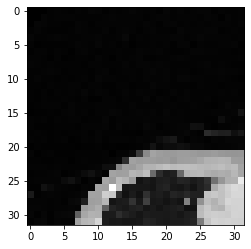

In [ ]:
plt.imshow(X_i_te[0,:,:,1],cmap='gray')

[9.9906856e-01 2.8588722e-04 2.2434858e-04 4.2124576e-04]
Y: nonROI


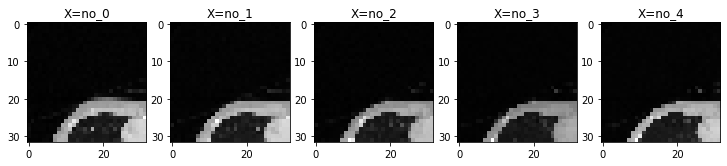

In [ ]:
# 1 patch에는 다음과 같이 5개의 ct 조각(patch)들이 들어가 있습니다. 그리고 이러한 X를 모델에 넣으면  y값이 1개 나옵니다
fig=plt.figure(figsize=(15,15))
print(y_pred[0])
print(f"Y: {label_list[np.argmax(y_pred[0])]}")
for window_idx in range(X_i_te.shape[-1]):
    fig.add_subplot(1, 6, window_idx+1)
    plt.imshow(X_i_te[0,:,:,window_idx],cmap='gray')
    plt.title(f'X=no_{window_idx}')



[9.9906856e-01 2.8588722e-04 2.2434858e-04 4.2124576e-04]
Y: nonROI


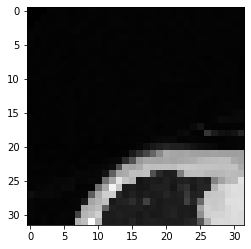

In [ ]:
# 1 patch (5개의 ct 조각) 을 겹쳐서 보여줄수도 있습니다. 그리고 이러한 X를 모델에 넣으면 y 값이 1개 나옵니다
print(y_pred[0])
print(f"Y: {label_list[np.argmax(y_pred[0])]}")
overlapped_x = X_i_te[0,:,:,:].sum(axis=2)
plt.imshow(overlapped_x, cmap='gray')

In [ ]:
# def concate_patches(start_idx,overlap=False):
#     temp1 = np.concatenate((X_i_te[start_idx,:,:,:],X_i_te[start_idx+1,:,:,:]), axis=1)
#     temp2 = np.concatenate((X_i_te[start_idx+2,:,:,:],X_i_te[start_idx+3,:,:,:]), axis=1)
#     temp_result = np.concatenate((temp1,temp2),axis=0)
#     if overlap:
#         temp_result = temp_result[:,:,0]+temp_result[:,:,1]+temp_result[:,:,2]+temp_result[:,:,3]+temp_result[:,:,4]
#     return temp_result
# concate_patches(0).shape

(64, 64, 5)

[9.9975246e-01 7.8672136e-05 6.3594867e-05 1.0531319e-04]
nonROI


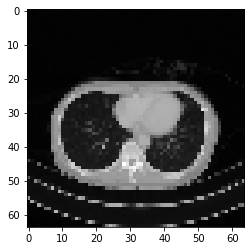

In [ ]:
# 4개의 patch를 모으면 CT 이미지 크기가 됩니다.
print(np.mean(np.array([y_pred[0],y_pred[1],y_pred[2],y_pred[3]]),axis=0))
print(label_list[np.argmax(np.mean(np.array([y_pred[0],y_pred[1],y_pred[2],y_pred[3]]),axis=0))])
plt.imshow(concate_patches(0,overlap=True), cmap='gray')

In [ ]:
def concate_patches(start_idx,overlap=False):
    temp1 = np.concatenate((X_i_te[start_idx,:,:,:].sum(axis=2),X_i_te[start_idx+1,:,:,:].sum(axis=2)), axis=1)
    temp2 = np.concatenate((X_i_te[start_idx+2,:,:,:].sum(axis=2),X_i_te[start_idx+3,:,:,:].sum(axis=2)), axis=1)
    temp_result = np.concatenate((temp1,temp2),axis=0)
    if overlap:
        temp_result = temp_result[:,:,0]+temp_result[:,:,1]+temp_result[:,:,2]+temp_result[:,:,3]+temp_result[:,:,4]
    return temp_result
concate_patches(0).shape

(64, 64)

In [ ]:
patches_no_per_image = 4
def concatenate_Xs(patches_no_per_image,X_i_te):
    x_list = []
    x_img_cnt = X_i_te.shape[0]//patches_no_per_image
    for i in range(x_img_cnt):
        x_list.append(concate_patches(i*patches_no_per_image))
    x_list = np.array(x_list)
    return x_list
X_concat = concatenate_Xs(patches_no_per_image,X_i_te)

X_concat.shape

(2590, 64, 64)

In [ ]:
patches_no_per_image = 4

def concatenate_Ys(patches_no_per_image,y_pred):
    y_list = []
    y_img_cnt = y_pred.shape[0]//patches_no_per_image
    for i in range(y_img_cnt):
        y_temp = np.mean(y_pred[i*patches_no_per_image:(i+1)*patches_no_per_image,:],axis=0)
        # y_temp = np.zeros(shape=(patches_no_per_image))
        # for j in range(patches_no_per_image):
        #     y_temp += y_pred[patches_no_per_image*i+j]
        y_list.append(y_temp)
    y_list = np.array(y_list)
    return y_list
Y_concat=concatenate_Ys(patches_no_per_image,y_pred)
print(Y_concat.shape)

(2590, 4)


In [ ]:
Y_concat[0].sum()

0.99999994

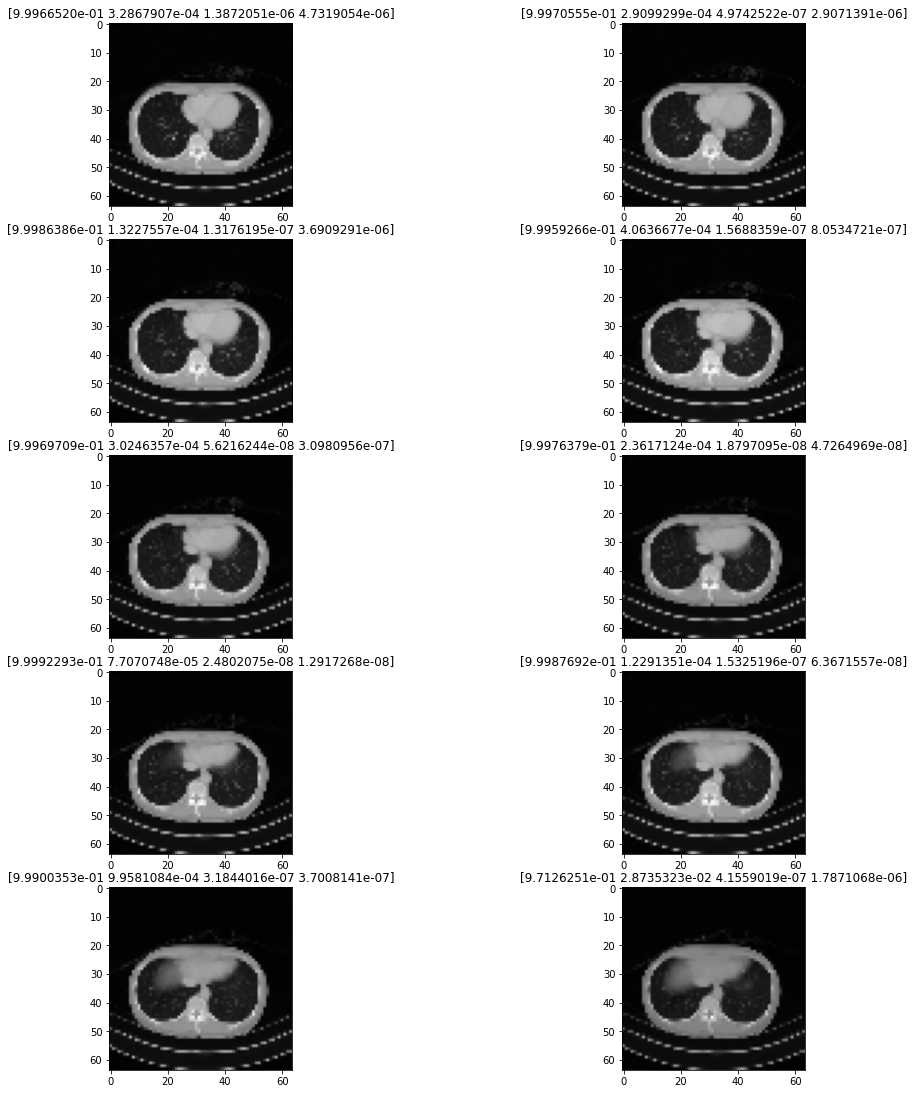

In [ ]:
# 10개만 보여주기
cnt = 1
fig=plt.figure(figsize=(15,15))

for x, y in zip(X_concat,Y_concat):

    fig.add_subplot(5,2, cnt)
    plt.title(f"{y}")
    plt.tight_layout(False)
    plt.imshow(x, cmap='gray')
    if cnt ==10:
        break
    cnt +=1

